# Regresión sobre el precio de vehículos de segunda mano
Este notebook muestra el proceso completo del proyecto para predecir el precio de un vehículo de segunda mano a partir de sus características.

## Setup

Librerías importadas en el proyecto.

In [1]:
import numpy as np
import pandas as pd

import os
import warnings
from collections import defaultdict

from IPython.display import IFrame

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from scipy.stats import kstest, norm, mannwhitneyu, f_oneway

Variables globales utilizadas.

In [2]:
RANDOM_SEED = 1337
DATA_PATH = os.path.join(os.pardir, "data")

Enunciado del problema.

In [3]:
IFrame(os.path.join(os.pardir, "info", "lab1.pdf"), width=1200, height=920)

## Análisis exploratorio de los datos

Vamos a cargar todos los datos en memoria y a echarles un primer vistazo.

In [3]:
dataframes = {}
for file in filter(lambda x: x.endswith(".csv"), os.listdir(DATA_PATH)):
    name = file.split(".")[0]
    print(name)
    dataframes[name] = pd.read_csv(os.path.join(DATA_PATH, file))
    display(dataframes[name])

audi


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


bmw


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0
...,...,...,...,...,...,...,...,...,...
10776,X3,2016,19000,Automatic,40818,Diesel,150,54.3,2.0
10777,5 Series,2016,14600,Automatic,42947,Diesel,125,60.1,2.0
10778,3 Series,2017,13100,Manual,25468,Petrol,200,42.8,2.0
10779,1 Series,2014,9930,Automatic,45000,Diesel,30,64.2,2.0


cclass


,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


focus


,model,year,price,transmission,mileage,fuelType,engineSize
0,Focus,2016,8000,Manual,38852,Petrol,1.0
1,Focus,2019,13400,Manual,11952,Petrol,1.0
2,Focus,2019,14600,Manual,22142,Petrol,1.5
3,Focus,2016,9450,Manual,14549,Diesel,1.6
4,Focus,2015,9999,Manual,7010,Diesel,1.6
...,...,...,...,...,...,...,...
5449,Focus,2019,18745,Manual,7855,Diesel,2.0
5450,Focus,2019,16350,Manual,13891,Petrol,1.0
5451,Focus,2019,16850,Manual,13452,Petrol,1.0
5452,Focus,2019,17310,Automatic,13376,Petrol,1.0


ford


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


hyundi


,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0
...,...,...,...,...,...,...,...,...,...
4855,I30,2016,8680,Manual,25906,Diesel,0,78.4,1.6
4856,I40,2015,7830,Manual,59508,Diesel,30,65.7,1.7
4857,I10,2017,6830,Manual,13810,Petrol,20,60.1,1.0
4858,Tucson,2018,13994,Manual,23313,Petrol,145,44.8,1.6


merc


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0
...,...,...,...,...,...,...,...,...,...
13114,C Class,2020,35999,Automatic,500,Diesel,145,55.4,2.0
13115,B Class,2020,24699,Automatic,2500,Diesel,145,55.4,2.0
13116,GLC Class,2019,30999,Automatic,11612,Diesel,145,41.5,2.1
13117,CLS Class,2019,37990,Automatic,2426,Diesel,145,45.6,2.0


skoda


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Octavia,2017,10550,Manual,25250,Petrol,150,54.3,1.4
1,Citigo,2018,8200,Manual,1264,Petrol,145,67.3,1.0
2,Octavia,2019,15650,Automatic,6825,Diesel,145,67.3,2.0
3,Yeti Outdoor,2015,14000,Automatic,28431,Diesel,165,51.4,2.0
4,Superb,2019,18350,Manual,10912,Petrol,150,40.9,1.5
...,...,...,...,...,...,...,...,...,...
6262,Yeti,2014,11440,Semi-Auto,14569,Petrol,160,44.8,1.2
6263,Octavia,2014,10990,Semi-Auto,49999,Petrol,30,56.5,1.4
6264,Fabia,2017,9500,Semi-Auto,17131,Petrol,145,61.4,1.0
6265,Citigo,2016,5999,Manual,21747,Petrol,20,62.8,1.0


toyota


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0
...,...,...,...,...,...,...,...,...,...
6733,IQ,2011,5500,Automatic,30000,Petrol,20,58.9,1.0
6734,Urban Cruiser,2011,4985,Manual,36154,Petrol,125,50.4,1.3
6735,Urban Cruiser,2012,4995,Manual,46000,Diesel,125,57.6,1.4
6736,Urban Cruiser,2011,3995,Manual,60700,Petrol,125,50.4,1.3


vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Corsa,2018,7885,Manual,9876,Petrol,145,55.4,1.4
1,Corsa,2019,11995,Manual,2500,Petrol,145,54.3,1.4
2,Corsa,2017,9777,Automatic,9625,Petrol,145,47.9,1.4
3,Corsa,2016,8500,Manual,25796,Petrol,30,55.4,1.4
4,Corsa,2019,10000,Manual,3887,Petrol,145,43.5,1.4
...,...,...,...,...,...,...,...,...,...
13627,Tigra,2007,2499,Manual,48640,Petrol,165,46.3,1.4
13628,Vectra,2007,1795,Manual,75000,Petrol,240,39.2,1.8
13629,Vectra,2005,1495,Manual,74000,Petrol,235,38.7,1.8
13630,Vectra,2008,1695,Automatic,131000,Diesel,200,39.8,1.9


vw


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5
...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
15153,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
15154,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
15155,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


Lo primero que se ve es que casi todos los ficheros tienen las mismas columnas. Las variables `model`, `transmission` y `fueltype` son categóricas y el resto son numéricas. Hay un par de problemas a primera vista, como que `hyundi.csv` tiene un nombre diferente en la columna `tax` y que a dos ficheros les faltan las columnas `tax` y `mpg`.

### Análisis de duplicados

Un modelo con datos duplicados tiende siempre a sesgarse hacia esos datos. Un 10% de datos duplicados eleva la probablidad de sesgar el modelo a un 89% \[1\].

In [4]:
duplicate_count = 0
for key in filter(lambda x: x not in ["focus", "cclass"], dataframes):
    duplicate_count += dataframes[key].duplicated().sum()
print(duplicate_count)

1475


El procentaje de elementos duplicados no es muy alto para el problema, pero es una buena práctica eliminarlos, así que será un paso del preprocesamiento.

### Análisis de los ficheros de la misma marca

En primer lugar se ve que los archivos `cclass.csv` y `focus.csv` no tienen las columnas `tax` y `mpg`. Ya que estos son modelos de otras marcas (Ford en `ford.csv` y Mercedes en `merc.csv`), vamos a ver si podemos mezclarlos con el resto de modelos de la marca.

In [6]:
print(dataframes["focus"]["model"].unique())
print(dataframes["ford"]["model"].unique())

[' Focus']
[' Fiesta' ' Focus' ' Puma' ' Kuga' ' EcoSport' ' C-MAX' ' Mondeo' ' Ka+'
 ' Tourneo Custom' ' S-MAX' ' B-MAX' ' Edge' ' Tourneo Connect'
 ' Grand C-MAX' ' KA' ' Galaxy' ' Mustang' ' Grand Tourneo Connect'
 ' Fusion' ' Ranger' ' Streetka' ' Escort' ' Transit Tourneo']


In [7]:
print(dataframes["cclass"]["model"].unique())
print(dataframes["merc"]["model"].unique())

[' C Class']
[' SLK' ' S Class' ' SL CLASS' ' G Class' ' GLE Class' ' GLA Class'
 ' A Class' ' B Class' ' GLC Class' ' C Class' ' E Class' ' GL Class'
 ' CLS Class' ' CLC Class' ' CLA Class' ' V Class' ' M Class' ' CL Class'
 ' GLS Class' ' GLB Class' ' X-CLASS' '180' ' CLK' ' R Class' '230' '220'
 '200']


El nombre del modelo coincide con lo que se espera: todos los vehículos de `focus.csv` son modelo Focus y todos los de `cclass.csv` son de modelo C Class.

Ya que no conocemos de dónde vienen los datos, una posibilidad es que todas las filas de `cclass.csv` y `focus.csv` provengan originalmente de `merc.csv` y `ford.csv` respectivamente. Si añadimos esas filas sin pensar mucho, es posible que estemos duplicando algunos datos sin razón. Vamos a ver si son duplicados:

In [66]:
unique_rows = defaultdict(lambda: 0)
repeated_rows = defaultdict(lambda: 0)
for source, dest in zip(["cclass", "focus"], ["merc", "ford"]):
    source_df = dataframes[source]
    dest_df = dataframes[dest]
    for index, row in source_df.iterrows():
        filtered_df = dest_df[(dest_df["model"] == row["model"]) &
                              (dest_df["year"] == row["year"]) &
                              (dest_df["price"] == row["price"]) &
                              (dest_df["transmission"] == row["transmission"]) &
                              (dest_df["mileage"] == row["mileage"]) &
                              (dest_df["fuelType"] == row["fuelType"]) &
                              (dest_df["engineSize"] == row["engineSize"])]
        if filtered_df.empty:
            unique_rows[source] += 1
        else:
            repeated_rows[source] += 1
            
print(unique_rows)
print(repeated_rows)

defaultdict(<function <lambda> at 0x0000022F9AA3C1F8>, {'cclass': 265, 'focus': 784})
defaultdict(<function <lambda> at 0x0000022F9AA3C678>, {'cclass': 3634, 'focus': 4670})


In [70]:


columns = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'engineSize']

df_merged_ford = dataframes["ford"][columns].merge(dataframes["focus"][columns], how='outer', indicator='union')
df_merged_merc = dataframes["merc"][columns].merge(dataframes["cclass"][columns], how='outer', indicator='union')

print(df_merged_ford[df_merged_ford.union=='right_only'].shape[0])
print(df_merged_merc[df_merged_merc.union=='right_only'].shape[0])

print("Registros duplicados en el dataset focus respecto de ford: ", dataframes["focus"].shape[0] - df_merged_ford[df_merged_ford.union=='right_only'].shape[0])
print("Registros duplicados en el dataset cclass respecto de merc: ", dataframes["cclass"].shape[0] - df_merged_merc[df_merged_merc.union=='right_only'].shape[0])



784
265
Registros duplicados en el dataset focus respecto de ford:  4670
Registros duplicados en el dataset cclass respecto de merc:  3634


Aunque la mayoría de las filas son duplicadas, hay una proporción alta de filas nuevas y usables. Lo que haremos será mezclar los ficheros (teniendo en cuenta que `cclass` y `focus` no tienen columnas `tax` y `mpg`) y luego eliminar los duplicados.

### Análisis antes de mezclar los ficheros

Vamos a hacer unos análisis preliminares para ver si es posible, y en caso de que lo sea, cuánto trabajo llevaría, mezclar todos los ficheros csv en un solo `DataFrame`.

#### Variables categóricas

Vamos a echar un vistazo a los posibles valores que toman las variables categóricas.

In [9]:
for column in ["transmission", "fuelType"]:
    print(column, end=': ')
    total = set()
    for key in dataframes:
        total |= set(dataframes[key][column].unique())
    print(total)

transmission: {'Semi-Auto', 'Automatic', 'Manual', 'Other'}
fuelType: {'Diesel', 'Other', 'Petrol', 'Hybrid', 'Electric'}


Estos datos están muy limpios y se pueden mezclar sin problemas. Los tipos `Other` puede que den problemas, así que vamos a ver cuántos son:

In [10]:
transmission_other = 0
fuelType_other = 0
for key in dataframes:

    transmission_counts = dataframes[key]["transmission"].value_counts()
    if "Other" in transmission_counts:
        transmission_other += transmission_counts["Other"]

    fuelType_counts = dataframes[key]["fuelType"].value_counts()
    if "Other" in fuelType_counts:
        fuelType_other += fuelType_counts["Other"]

print(f"transmission=Other count: {transmission_other}")
print(f"fuelType=Other count: {fuelType_other}")

transmission=Other count: 10
fuelType=Other count: 253


#### Nombre de modelo único

Para los modelos de regresión, lo ideal sería que se sepa la marca de la instancia como algo separado del modelo, ya que es posible que haya marcas de lujo que siempre cuesten más independientemente de las características del vehículo. Sin embargo, si el nombre del modelo de vehículo está repetido para distintas marcas, eso puede dar lugar a problemas. Vamos a comprobar si es el caso:

In [11]:
car_models = set()
for key in dataframes:
    make_models = set(dataframes[key]["model"].unique())
    intersect = car_models & make_models
    if intersect != set():
        print(key, intersect)
    car_models |= make_models

ford {' Focus'}
merc {' C Class'}


Ya sabíamos que esos dos iban a fallar, pero hemos visto que ninguno más nos da problemas.

### Creación de un único DataFrame

Vamos a juntar todos los dataframes de los distintos ficheros csv en un solo objeto que podremos evaluar más adelante.

Antes de nada, renombramos la columna `tax` de Hyundai para que sea consistente con las demás.

In [12]:
dataframes["hyundi"].rename(columns={"tax(£)": "tax"}, inplace=True)

Vamos a mezclar los archivos `merc.csv` con `cclass.csv` y `ford.csv` con `focus.csv`. Esto significa que las filas que procedan de `cclass.csv` y `focus.csv` tendrán valores `nan` en las columnas `tax` y `mpg`, que es algo que tendremos que tener en cuenta más adelante.

In [13]:
dataframes["merc"] = dataframes["merc"].append(dataframes["cclass"])
dataframes["ford"] = dataframes["ford"].append(dataframes["focus"])
del dataframes["cclass"], dataframes["focus"]

Y ahora vamos a generar un único `DataFrame` que contenga todos los datos del proyecto. Para saber qué marca tiene cada instancia vamos a añadir una columna `make`.

In [14]:
columns = [
    "make", "model", "year", "transmission", "mileage", "fuelType", "tax",
    "mpg", "engineSize", "price"
]

df = pd.DataFrame(columns=columns)

for key in dataframes:
    dataframes[key]["make"] = key
    assert set(dataframes[key].columns) == set(columns)
    df = df.append(dataframes[key])

display(df)

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,audi,A1,2017,Manual,15735,Petrol,150,55.4,1.4,12500
1,audi,A6,2016,Automatic,36203,Diesel,20,64.2,2.0,16500
2,audi,A1,2016,Manual,29946,Petrol,30,55.4,1.4,11000
3,audi,A4,2017,Automatic,25952,Diesel,145,67.3,2.0,16800
4,audi,A3,2019,Manual,1998,Petrol,145,49.6,1.0,17300
...,...,...,...,...,...,...,...,...,...,...
15152,vw,Eos,2012,Manual,74000,Diesel,125,58.9,2.0,5990
15153,vw,Fox,2008,Manual,88102,Petrol,145,46.3,1.2,1799
15154,vw,Fox,2009,Manual,70000,Petrol,200,42.0,1.4,1590
15155,vw,Fox,2006,Manual,82704,Petrol,150,46.3,1.2,1250


Este `df` es el dataframe que vamos a preprocesar más adelante. Pero antes de eso, vamos a explorar un poco más los datos.

### Análisis de variables numéricas

#### Comprobaciones de los tipos de datos

Lo primero es ver si las variables numéricas realmente son tales. Es habitual que aparezcan en el `DataFrame` como `object` o `str`, así que tendremos que cambiar lo que corresponda.

In [15]:
df.dtypes

make             object
model            object
year             object
transmission     object
mileage          object
fuelType         object
tax              object
mpg             float64
engineSize      float64
price            object
dtype: object

Las variables `year`, `price`, `mileage`, y `tax` son numéricas, pero aparecen como `object`. Vamos a cambiarlo:

In [16]:
df["year"] = df["year"].astype("int32")
df[["price", "mileage", "tax"]] = df[["price", "mileage", "tax"]].astype("float64")
df

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,audi,A1,2017,Manual,15735.0,Petrol,150.0,55.4,1.4,12500.0
1,audi,A6,2016,Automatic,36203.0,Diesel,20.0,64.2,2.0,16500.0
2,audi,A1,2016,Manual,29946.0,Petrol,30.0,55.4,1.4,11000.0
3,audi,A4,2017,Automatic,25952.0,Diesel,145.0,67.3,2.0,16800.0
4,audi,A3,2019,Manual,1998.0,Petrol,145.0,49.6,1.0,17300.0
...,...,...,...,...,...,...,...,...,...,...
15152,vw,Eos,2012,Manual,74000.0,Diesel,125.0,58.9,2.0,5990.0
15153,vw,Fox,2008,Manual,88102.0,Petrol,145.0,46.3,1.2,1799.0
15154,vw,Fox,2009,Manual,70000.0,Petrol,200.0,42.0,1.4,1590.0
15155,vw,Fox,2006,Manual,82704.0,Petrol,150.0,46.3,1.2,1250.0


#### Observación general de datos numéricos

En esta sección obervaremos los datos numéricos de forma general, para ver si hay algo que destaque y pueda ser relevante. Además, es posible que haya datos erróneos. Vamos a buscarlos, y si los encontramos, a corregirlos.

In [17]:
df.describe()

,year,mileage,tax,mpg,engineSize,price
count,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000,108540.000000
mean,2017.098028,23025.928469,120.299838,55.166825,1.661644,16890.124046
std,2.130057,21176.423684,63.150926,16.138522,0.557058,9756.266820
min,1970.000000,1.000000,0.000000,0.300000,0.000000,450.000000
25%,2016.000000,7491.750000,125.000000,47.100000,1.200000,10229.500000
50%,2017.000000,17265.000000,145.000000,54.300000,1.600000,14698.000000
75%,2019.000000,32236.000000,145.000000,62.800000,2.000000,20940.000000
max,2060.000000,323000.000000,580.000000,470.800000,6.600000,159999.000000


Lo primero que salta a la vista es el año máximo. ¡Es imposible que haya vehículos de años posteriores al actual! Lo corregimos filtrando `df` a las filas con años menores o iguales a 2020.

In [16]:
df = df[df["year"] <= 2020]

El resto de valores máximos y mínimos son muy extremos, pero no imposibles para lo que representan, así que se quedan en el modelo.

#### Tests de normalidad

El [test de Kolmogorov-Smirnov](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) nos permite ver si una variable sigue una distribución normal o no.

In [17]:
numeric_variables = ["year", "price", "mileage", "tax", "mpg", "engineSize"]

for column in numeric_variables:
    mu, sigma = norm.fit(df[column].dropna())
    n = norm(loc=mu, scale=sigma)
    print(f"{column}: hypothesis {'rejected' if kstest(df[column].dropna(), n.cdf).pvalue < 0.05 else 'not rejected'}")

year: hypothesis rejected
price: hypothesis rejected
mileage: hypothesis rejected
tax: hypothesis rejected
mpg: hypothesis rejected
engineSize: hypothesis rejected


Parece que ninguna de ellas sigue una distribución normal. Sin embargo, es posible aproximar una normal, así que vamos a echar un vistazo a los histogramas.

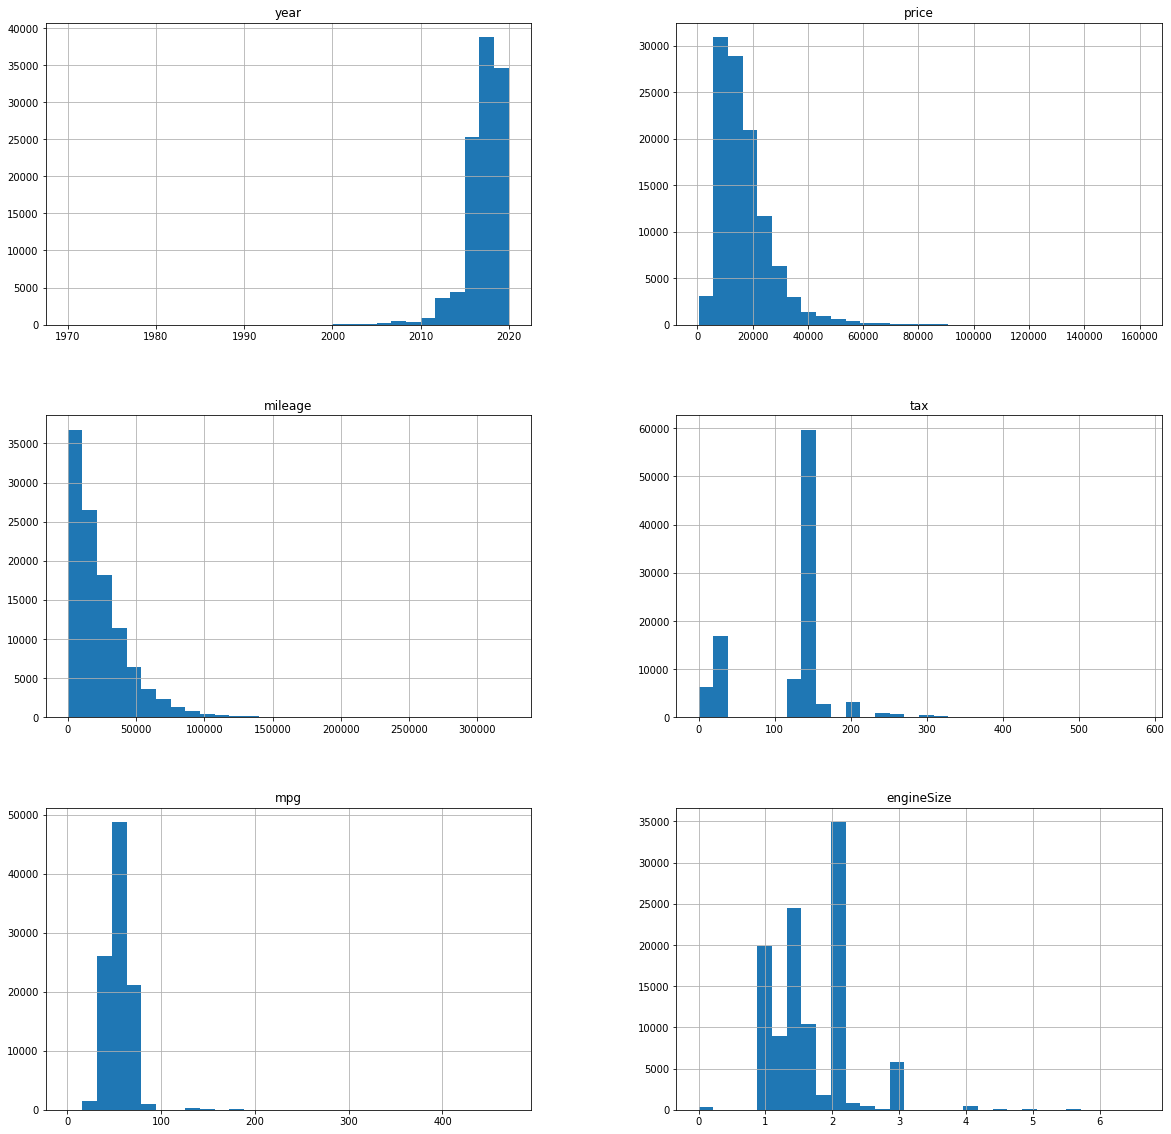

In [18]:
df[numeric_variables].hist(figsize=(20, 20), bins=30)
plt.show()

La variable `mpg` parece que podría ser normal si no fuera por sus outliers. Si eliminando los outliers la distribución es normal, podremos normalizar en el preprocesamiento.

Not a normal distribution


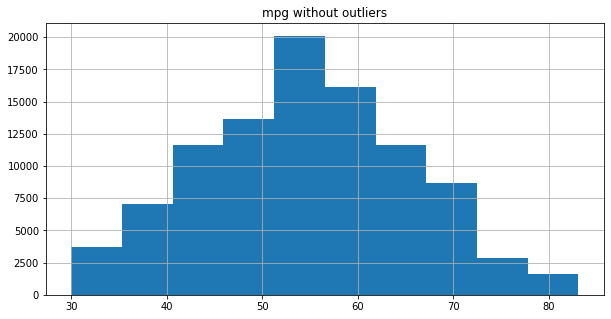

In [19]:
mpg_std = df["mpg"][(df["mpg"] < np.percentile(df["mpg"].dropna(), 99))
                    & (df["mpg"] > np.percentile(df["mpg"].dropna(), 1))]

mu, sigma = norm.fit(mpg_std)
n = norm(loc=mu, scale=sigma)
if kstest(mpg_std, n.cdf).pvalue < 0.05:
    print("Not a normal distribution")
else:
    print("Test inconclusive")

plt.figure(figsize=(10, 5))
plt.hist(mpg_std, bins=10)
plt.grid(True)
plt.title("mpg without outliers")
plt.show()

La distribución de `mpg` no es normal aunque se eliminen estos outliers. Los tests dan p-valores menores de 0.05 y el histograma está sesgado a la derecha.

### Análisis de correlaciones

Puede ser interesante observar las correlaciones entre las variables de entrada y la variable objetivo, ya que si hay alguna variable que no afecte al resultado, podremos eliminarla sin problemas simplificando el espacio de búsqueda.

#### Correlaciones con variables numéricas

En primer lugar, observamos las correlaciones ([Pearson $r$](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) con las variables numéricas.

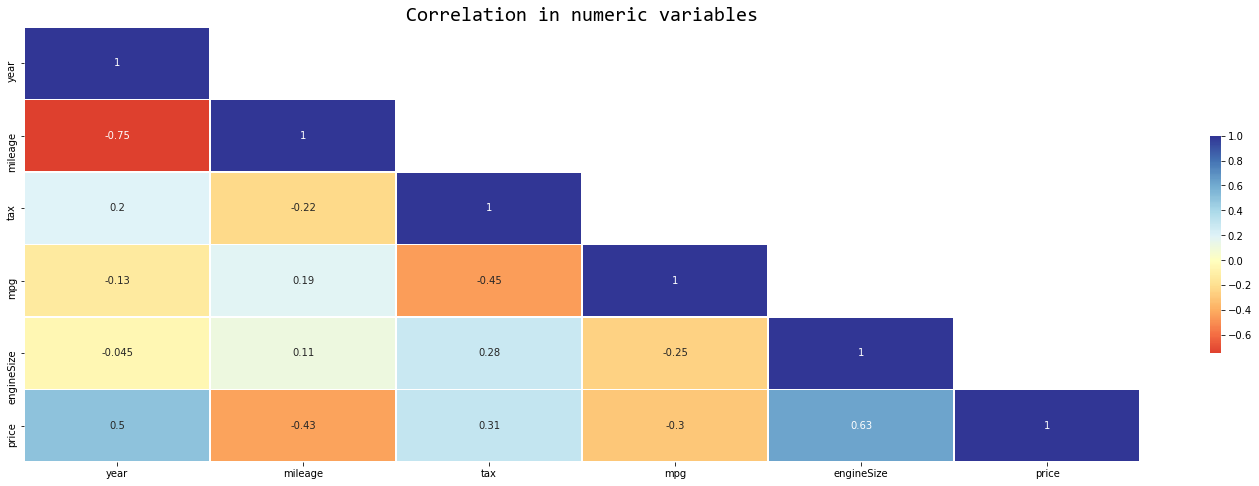

In [22]:
corr = df.corr(method="pearson")

plt.figure(figsize=(25, 8))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(corr, mask=mask, cmap="RdYlBu", center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
    
plt.title("Correlation in numeric variables", fontdict={"family": "Consolas", "size": 20})
plt.show()

En general, todos los pares de variables tienen bastante correlación. Sobre todo la variable `price`, que es nuestro objetivo. Sin embargo, en relación a la variable objetivo `price` hay otras variables como `tax` y `mpg` que presentan una correlación menor. 

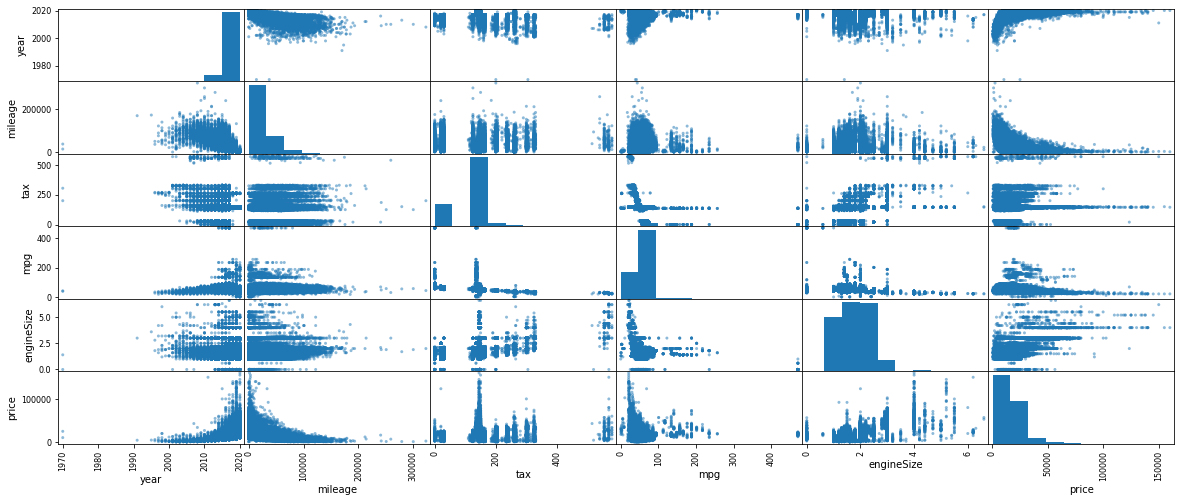

In [21]:
pd.plotting.scatter_matrix(df, figsize=(20, 8))
plt.show()

Con la matriz que muestra los diagramas de dispersión por cada par de variables podemos observar lo que ya se veía con el gráfico de correlación. Las variables que más correlación presentan con la variable objetivo `price` son `year`, `mileage` y `engineSize`.

#### Correlaciones con variables categóricas

La correlación con las variables categóricas no se puede cuantificar. Sin embargo, podemos ver si hay relación entre estas variables categóricas y la variable objetivo con el [U-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) de Mann-Whitney-Wilcoxon si son dos variables, con [ANOVA](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) si son más de dos, y siempre con histogramas.

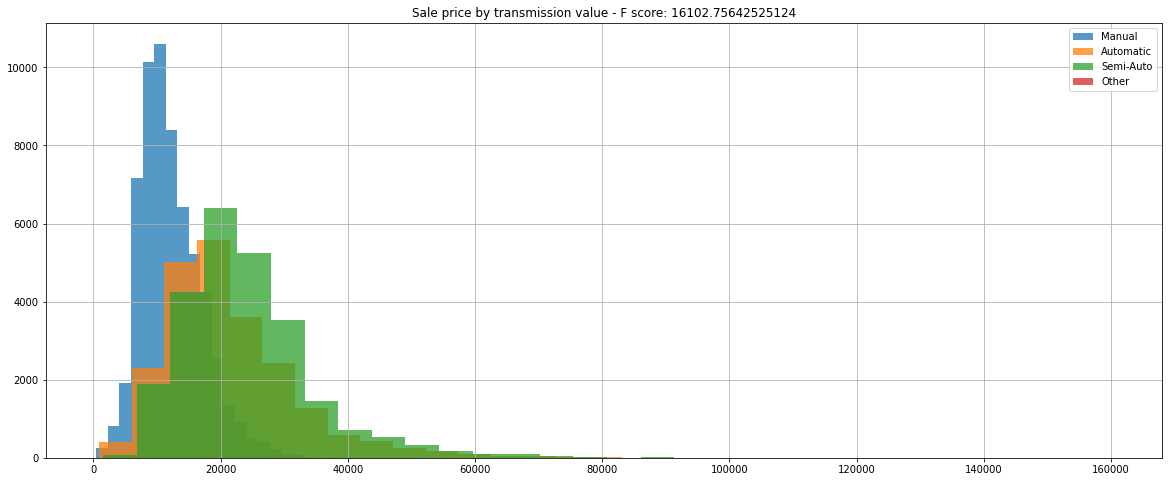

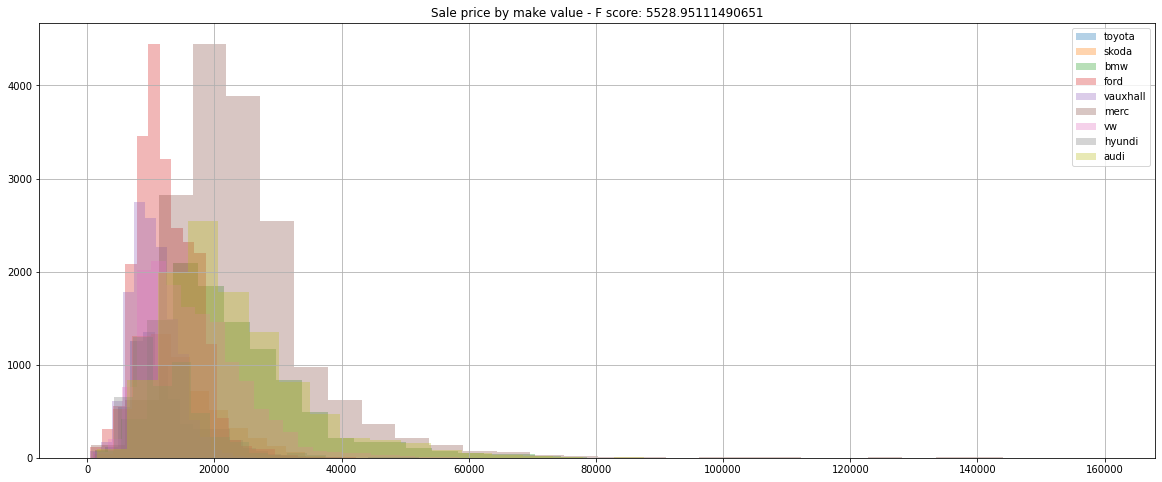

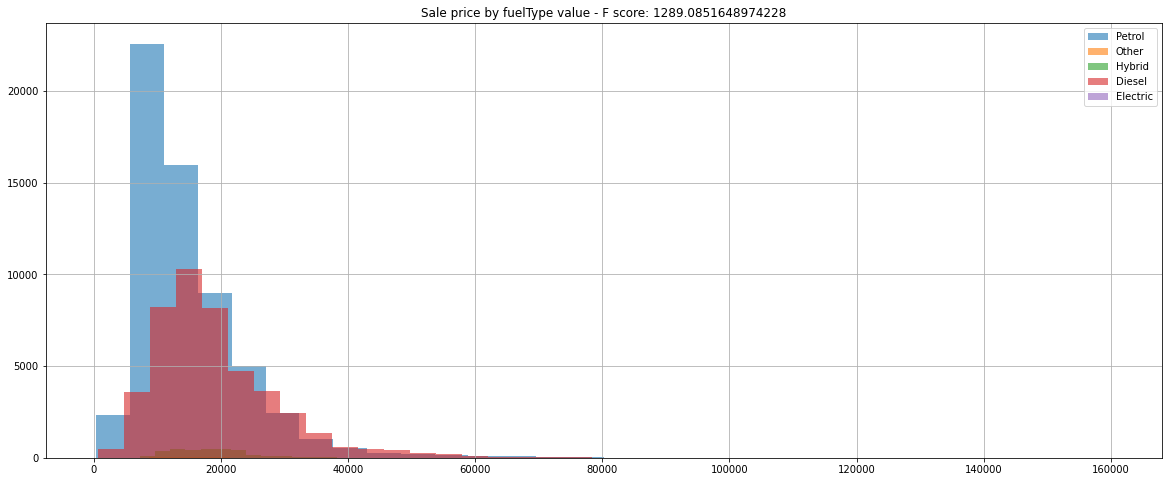

In [24]:
categorical_variables = ["transmission", "make", "fuelType"] # Omitimos model, porque hay demasiados tipos como para hacer este test.

def divide_category(df, var):
    """
    Divide a dataframe in several dataframes, grouping by variable `var`.
    """
    index = []
    ret = []
    unique_categories = df[var].unique()
    
    for cat in unique_categories:
        category_df = df[df[var] == cat]
        index.append(cat)
        ret.append(category_df)
        
    return index, ret

for var in categorical_variables:
    index, divided_data = divide_category(df, var)
    
    prices = [x.price for x in divided_data]
    
    plt.figure(figsize=(20, 8))
    if len(index) != 2:
        plt.title(f"Sale price by {var} value - F score: {f_oneway(*prices).statistic}")
    else:
        plt.title(f"Sale price by {var} value - U score: {mannwhitneyu(*prices).statistic}")

    for i, category_data in zip(index, divided_data):
        plt.hist(category_data.price, label=i, alpha=3/len(index), bins=30)
        
    plt.legend()
    plt.grid()
        
    plt.show()

Todas las variables están claramente relacionadas con la variable objetivo: los histogramas tienen poco que ver entre ellos y el test ANOVA da un resultado mayor a 1000 en todos los casos.

Parece que todas las variables son relevantes para la variable objetivo, y no nos podemos deshacer de ninguna.

## Preprocesamiento

Para el preprocesamiento de los datos vamos a crear un pipeline estructurado, que aplique una serie de pasos a cada columna con cuidado.

### Tratamiento de los datos duplicados

Vamos a eliminar los datos duplicados del `DataFrame`.

In [5]:
df.merge(df, how='inner')

#columns = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'engineSize']

#df_focus = dataframes["ford"][columns]
#df_ford = dataframes["focus"][columns]

#df_focus.merge(df_ford, how='inner')

NameError: name 'df' is not defined

### Pipeline de variables categóricas

Las variables categóricas no necesitan demasiado preprocesamiento. Con codificar cada elemento en un vector es suficiente.

In [26]:
# Quizás sería interesante plantearse codificar transmission como ordinal en vez de con OneHot, 
# para que se preserve el orden y se vea que va de menor a mayor entre
# (Manual, Semi-Auto, Automatic). El problema es el tipo de transmisión Other, que no se podría localizar en ese eje.

categorical_pipeline = OneHotEncoder()

## Entrenamiento de modelos

## Referencias

\[1\] Sarracino, F. y Mikucka, M. (2016). Estimation bias due to duplicated observations: a Monte Carlo simulation. https://mpra.ub.uni-muenchen.de/69064/1/